In [1]:
#Import basic python packages for data analysis and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.lines as mlines
import pylab as plot
import matplotlib
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
import random
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import time
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
from mpl_toolkits.basemap import Basemap

from sklearn.externals import joblib

import decimal

import itertools

import overpy

### Import Sklearn packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet




### Import Scipy stats packages
from scipy.stats import pearsonr
from scipy.stats import boxcox


# Import statsmodel packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices


#Sequential Feature Selector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS



import re


import warnings
warnings.filterwarnings("ignore")

sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/home/shridhar/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# <b> <font size = 5> Generate a grid of points in East Bay Area </b> </font>

## <b> <font size = 4> Load the shapefile for Oakland </b> </font>

In [2]:
#Load the shapefile
oakland_geodf = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')
#Convert the geometry column which contains multiple polygons in the area to a list
oakland_geodf_list = oakland_geodf.geometry.tolist()

DriverError: Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp: No such file or directory

In [3]:
oakland_geodf.bounds.head()

,minx,miny,maxx,maxy
0,-122.203201,37.766082,-122.199654,37.768689
1,-122.263655,37.790802,-122.259209,37.797752
2,-122.299332,37.806055,-122.298030,37.806704
3,-122.196547,37.768351,-122.194987,37.769649
4,-122.184393,37.796296,-122.180658,37.799113


In [4]:
#Get the North, South, East and West bounds from the shapefile. These are the bounds within which we want to generate points
North = np.max(oakland_geodf.bounds.iloc[:,3])
South = np.min(oakland_geodf.bounds.iloc[:,1])
East = np.max(oakland_geodf.bounds.iloc[:,2])
West = np.min(oakland_geodf.bounds.iloc[:,0])

## <b> <font size = 4> Create function to generate evenly spaced points within bounds </b> </font>

In [5]:
"""This helper function checks of each point (X,y) is within the polygon. The shapely polygon for oakland contains a list of polygon, 
and the loop goes through every single polygon to check if the point lies within; returns True of False"""
def is_point_in_polys(poly_list, point):
    for poly in poly_list:
        if point.within(poly):
            return True
    return False

In [6]:
""" This function generates a grid of evenly spaced points within certain bounds. The function takes the bounds as inputs, and a square root of number of points that you want to generate. 
The function then generates evenly spaced points within the bounds, and checks if each combination of (x,y) lies within the shapefile polygons.
Points that lie within the polygon are stored in a separate shapefile and a geodataframe is generated."""

def random_points_within(North, South, East, West, num_points):
    min_x = West
    min_y = South 
    max_x = East
    max_y = North
    x = (np.linspace(min_x,max_x,num_points))
    y=  (np.linspace(min_y,max_y,num_points))
    xx,yy = np.meshgrid(x,y,sparse=True) #generates evenly spaced point grid
    xx = xx.reshape((np.prod(xx.shape),))
    yy = yy.reshape((np.prod(yy.shape),))
    list_points_in_oakland = []
    
    #The following lines of codes checks whether each combination of x and y lies within the polygon and only stores points within polygons
    for x in xx:
        for y in yy:
            random_point = Point([x, y])
            isptinpoly = is_point_in_polys(oakland_geodf_list, random_point)
            if isptinpoly:
                list_points_in_oakland.append(random_point)  
    #Creates a list of lists with y,x
    lats_longs = [(point.y, point.x) for point in list_points_in_oakland]
    
    crs = {'init': 'epsg:4326'}
    
    grid = gpd.GeoDataFrame(lats_longs, geometry=list_points_in_oakland, columns = ['Lat', 'Long'], crs = crs)
    return (grid)


In [8]:
###############################################
####### Set the number of points here #########
##############################################
grid = random_points_within(North, South, East, West, 100)

In [9]:
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')
#oakl = gpd.read_file('Oakland-shapefile/City of Oakland City Limits/geo_export_8db624a6-e1fa-4921-8dbb-b56e0dce297c.shp')
oakl.crs


{'init': 'epsg:4326'}

Text(0.5, 1, 'Location of point grid in Oakland area prior to filtering')

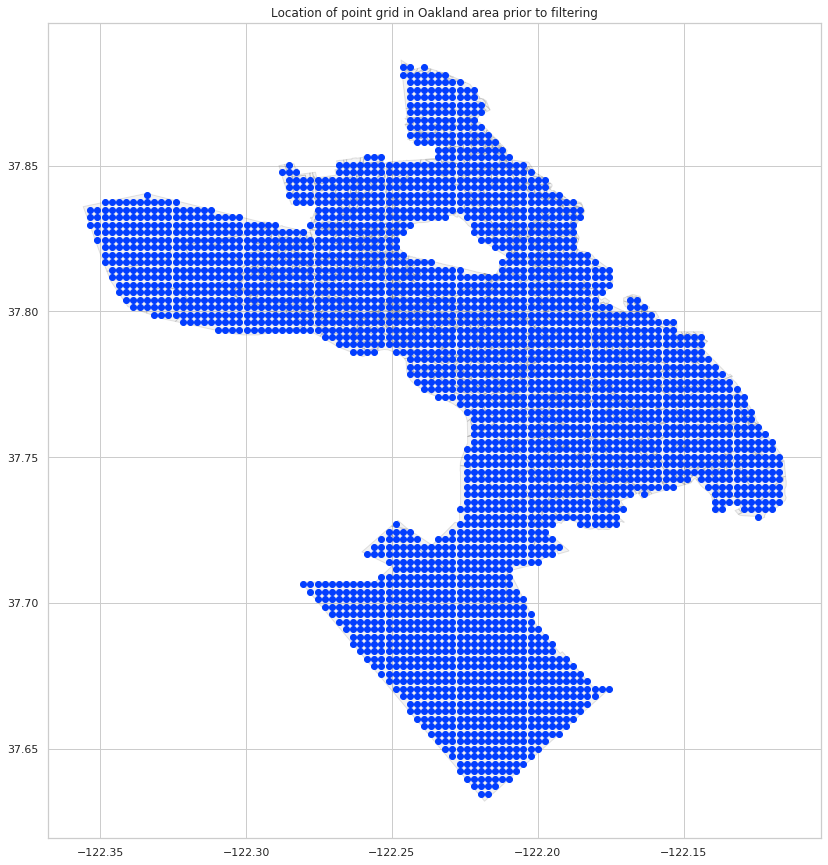

In [10]:
#Create Figure Axis and Set figure size
fig, ax = plt.subplots(figsize = (15,15))


# Basemap of City of Oakland from the Oakland shapefile
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black') 

plt.scatter(grid['Long'], grid['Lat'])

plt.title('Location of point grid in Oakland area prior to filtering')

## <b> <font size = 4> Determine if the point is located in land or water using MPL toolkits basemap </b> </font>

In [11]:
## Set the bounding box for Oakland/Berkeley area
bm = Basemap(llcrnrlon = -122.33, llcrnrlat =37.67, urcrnrlon = -122.10 , urcrnrlat =  37.9, area_thresh = 0.1, resolution = 'l' )   # default: projection='cyl'
for index, location in grid.iterrows(): 
    grid.loc[index, 'is_land'] = bm.is_land(location[1], location[0])



Text(0.5, 1, 'Location of point grid in Oakland area prior to filtering')

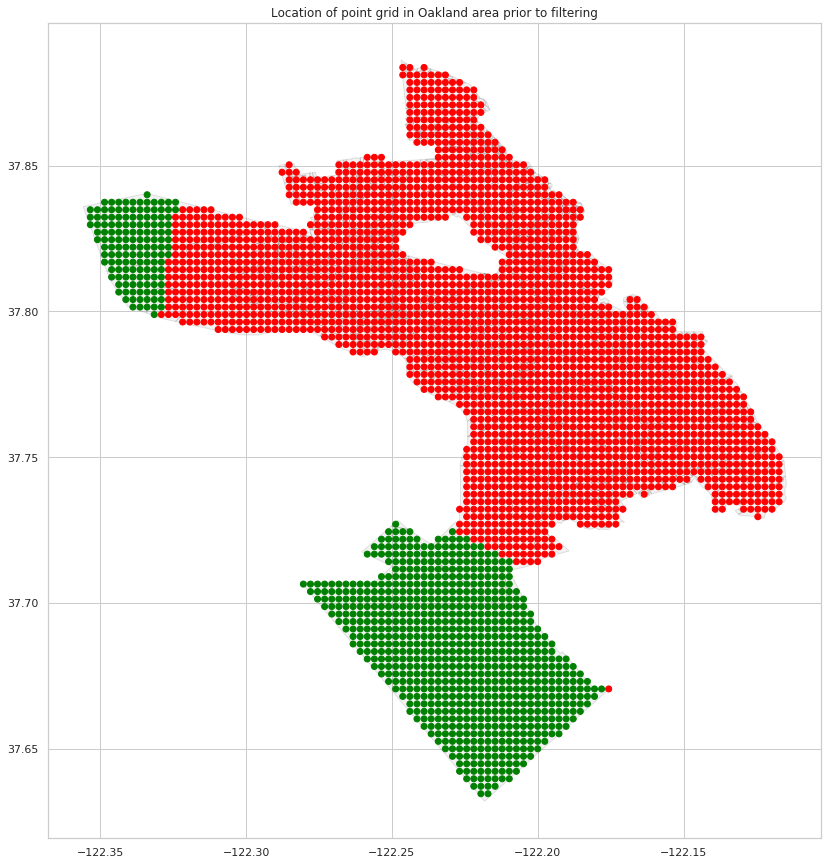

In [12]:
import matplotlib.colors as clrs

#Create Figure Axis and Set figure size
fig, ax = plt.subplots(figsize = (15,15))


# Basemap of City of Oakland from the Oakland shapefile
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black') 


cmap = clrs.ListedColormap(['red', 'green'])

plt.scatter(grid['Long'], grid['Lat'], cmap = cmap, c=(grid['is_land'] != True).astype(float))

plt.title('Location of point grid in Oakland area prior to filtering')

In [13]:
grid_filter = grid[grid['is_land'] == True]

In [14]:
grid_filter.head()

,Lat,Long,geometry,is_land
117,37.798945,-122.329059,POINT (-122.32906 37.79895),True
133,37.798945,-122.326624,POINT (-122.32662 37.79895),True
134,37.801513,-122.326624,POINT (-122.32662 37.80151),True
135,37.804080,-122.326624,POINT (-122.32662 37.80408),True
136,37.806647,-122.326624,POINT (-122.32662 37.80665),True


Text(0.5, 1, 'Location of point grid in Oakland area after removing points in water')

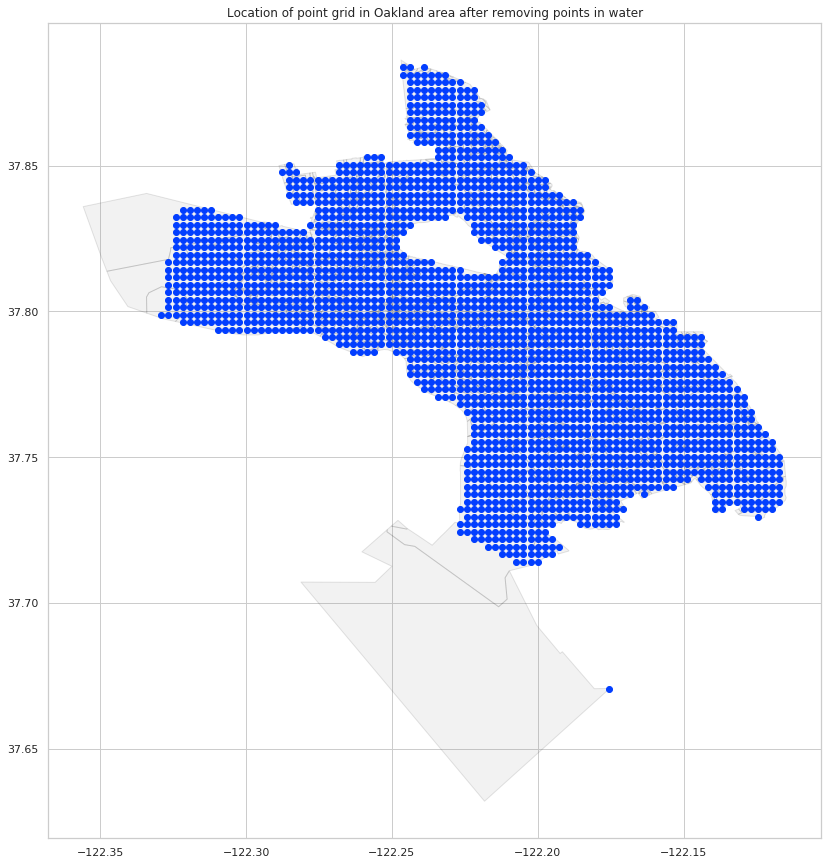

In [15]:
##Replot the points to see what got filtered out
#Create Figure Axis and Set figure size
fig, ax = plt.subplots(figsize = (15,15))


# Basemap of City of Oakland from the Oakland shapefile
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black') 

plt.scatter(grid_filter['Long'], grid_filter['Lat'])

plt.title('Location of point grid in Oakland area after removing points in water')

In [16]:
#### Write to csv
grid_filter.to_csv("Data/grid_points_oakland.csv")

# <b> <font size = 5> Feature Engineering </b> </font>

## <b> <font size = 4> Facility Data </b> </font>

In [17]:
Facility_PM = pd.read_csv("Data/PM_Facility_Data.csv")

In [18]:
Facility_PM.drop(columns = ['Unnamed: 0'], inplace=True)

In [19]:
Facility_NO2 = pd.read_csv("Data/NO2_Facility_Data.csv")

In [20]:
Facility_NO2.drop(columns = ['Unnamed: 0'], inplace=True)

### <b> <font size = 3 > Generate feature set for points - Distance from Facility </b> </font>

In [21]:
## First define a function that calculatis the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [22]:
def calculate_dist_to_facilities(Facility_df,grid):
    
    ### Create a column as eis-source-type by combining the eis-facility id and source type for each facility
    Facility_df['eis-source'] =  Facility_df['eis facility id'].apply(str)   + '-'  + Facility_df['source-type'] 
    
    ### Create a column as eis-source-ems by combining eis-source with emissions type
    Facility_df['eis-source-ems'] =    Facility_df['eis-source']   + '-' + Facility_df['ems-type']
    
    
    ### Add an empty column for distance
    Facility_df['dist'] = 0
    Facility_df['dist'].astype(float)
    
    
    # Create individual dataframes containing the latitude, longitude and distance
    Facility_lat = Facility_df[['eis-source-ems', 'latitude']]
    Facility_long = Facility_df[['eis-source-ems', 'longitude']]
    Facility_dist = Facility_df[['eis-source-ems', 'dist']]
    
    # Transpose all the dataframes
    Facility_lat = Facility_lat.T
    Facility_long = Facility_long.T
    Facility_dist = Facility_dist.T
    
    ## Make the header as the first row in each transposed dataframe. The header will be the 'eis-source-ems' row
    Facility_lat = Facility_lat.rename(columns=Facility_lat.iloc[0]).drop(Facility_lat.index[0])
    Facility_long = Facility_long.rename(columns=Facility_long.iloc[0]).drop(Facility_long.index[0])
    Facility_dist = Facility_dist.rename(columns=Facility_dist.iloc[0]).drop(Facility_dist.index[0])
    
    
    ## Add suffix to column header based on the dataframe type
    Facility_lat.columns = [str(col) + '_latitude' for col in Facility_lat.columns]
    Facility_long.columns = [str(col) + '_longitude' for col in Facility_long.columns]
    Facility_dist.columns = [str(col) + '_dist' for col in Facility_dist.columns]
    
    ## Remove index for each dataframe
    Facility_lat.reset_index(drop=True, inplace=True)
    Facility_long.reset_index(drop=True, inplace=True)
    Facility_dist.reset_index(drop=True, inplace=True)
    
    ### Combine individual dataframes into one
    Facility_combined = Facility_lat.join(Facility_long).join(Facility_dist)
    
    
    ### Sort based on column names
    Facility_combined = Facility_combined.reindex(columns=sorted(Facility_combined.columns))
    
    
    #Create a dataframe with number of rows = number of generated points in Oakland area
    Facility_combined = Facility_combined.loc[Facility_combined.index.repeat(len(grid))].reset_index(drop=True)

    
    ## Add the latitude and longitude of the point grid as the first two columns
    Facility_combined['lat_grid'] = grid['Lat']
    Facility_combined['lon_grid'] = grid['Long']
 
    # Convert distance or emissions distance column to float type
    for idx, col in enumerate(Facility_combined.columns):
        if "_dist" in col:
            Facility_combined[col] = pd.to_numeric(Facility_combined[col], downcast="float")
            
            
    #Calculate distance from each generated point to each facility. Returns distance in miles. 
    time1 = time.time()
    for index, row in Facility_combined.iterrows():
        for idx, col in enumerate(Facility_combined.columns):
            if "_dist" in col:
                Facility_combined.at[index,col] = float(distance((row.iloc[-2], row.iloc[-1]), (row.iloc[idx+1], row.iloc[idx+2])))*0.621
            #BC_Facility.at[index,col] = float(row.iloc[idx])
    time2 = time.time()            
    
    print(time2 - time1)
    
    ## Drop the facility_latitude and facility_longitude columns
    Facility_combined.drop(Facility_combined.columns[Facility_combined.columns.str.contains('_latitude')], axis=1, inplace=True)

    Facility_combined.drop(Facility_combined.columns[Facility_combined.columns.str.contains('_longitude')], axis=1, inplace=True)


    
    return Facility_combined
    

**BC dataset**

In [23]:
## Create input dataframe for the BC dataset
grid_BC_facilities_dist = calculate_dist_to_facilities(Facility_PM, grid)

44.24930691719055


In [24]:
## Set the bounding box for Oakland/Berkeley area and identify points that are not in land
bm = Basemap(llcrnrlon = -122.33, llcrnrlat =37.67, urcrnrlon = -122.10 , urcrnrlat =  37.9, area_thresh = 0.1, resolution = 'l' )   # default: projection='cyl'
for index, values in grid_BC_facilities_dist.iterrows(): 
    grid_BC_facilities_dist.loc[index, 'is_land'] = str(bm.is_land(values[-1], values[-2]))


In [25]:
#Drop points that are not in land and write to csv
grid_BC_facilities_dist_filter = grid_BC_facilities_dist[grid_BC_facilities_dist['is_land'] == 'True'] 

grid_BC_facilities_dist_filter.head()

,10452611-Manufacturing-low_dist,10452911-Retail-Res-high_dist,10453011-WWTP-medium_dist,10457011-Manufacturing-medium_dist,10457411-Manufacturing-high_dist,10457511-Manufacturing-high_dist,10457611-Manufacturing-high_dist,10457711-Foundaries-high_dist,10457911-ConcretePlant-medium_dist,10460411-Retail-Res-medium_dist,10460511-Retail-Res-high_dist,10461011-Retail-Res-low_dist,10461711-Retail-Res-medium_dist,10461911-Waste-medium_dist,10462111-Retail-Res-low_dist,10466511-FoodPlant-high_dist,10469511-Retail-Res-high_dist,10470711-Retail-Res-medium_dist,10471211-Retail-Res-low_dist,10472111-Retail-Res-low_dist,10472311-Retail-Res-medium_dist,10472411-Retail-Res-low_dist,10472611-EGen-high_dist,10473411-Retail-Res-low_dist,10473611-Manufacturing-medium_dist,10476211-Retail-Res-medium_dist,10476711-Manufacturing-high_dist,10476911-Transportation-medium_dist,10477111-Transportation-low_dist,10477311-Retail-Res-medium_dist,10477411-Waste-high_dist,10478111-Retail-Res-medium_dist,10478611-Retail-Res-low_dist,10478711-Retail-Res-medium_dist,10478811-Retail-Res-low_dist,10481011-Transportation-low_dist,10487211-Retail-Res-medium_dist,10488111-Retail-Res-medium_dist,10490111-Transportation-medium_dist,10490611-Retail-Res-low_dist,10492211-Retail-Res-low_dist,10492711-Manufacturing-medium_dist,10493211-Retail-Res-medium_dist,10494711-Manufacturing-medium_dist,10495311-Manufacturing-medium_dist,10496311-Retail-Res-medium_dist,10496511-Retail-Res-medium_dist,10496711-Retail-Res-medium_dist,10497111-Retail-Res-medium_dist,10497711-Retail-Res-medium_dist,10498611-Transportation-medium_dist,10500811-Retail-Res-low_dist,10501811-Retail-Res-medium_dist,10501911-Retail-Res-low_dist,10502011-Retail-Res-low_dist,10502111-Retail-Res-medium_dist,10502511-Retail-Res-low_dist,10502611-Retail-Res-low_dist,10502711-Retail-Res-medium_dist,10503011-Retail-Res-medium_dist,10504811-Retail-Res-low_dist,10505411-Manufacturing-medium_dist,10506911-Retail-Res-medium_dist,10507111-Manufacturing-medium_dist,10510811-AsphaltPlant-high_dist,10517111-Retail-Res-high_dist,10518411-FoodPlant-low_dist,10518911-ConcretePlant-high_dist,10523411-Manufacturing-high_dist,10707511-EGen-high_dist,10708011-Waste-high_dist,10708111-Manufacturing-high_dist,1088911-Retail-Res-medium_dist,1105111-ConcretePlant-high_dist,1106211-Retail-Res-high_dist,1106311-Retail-Res-low_dist,1106511-Retail-Res-medium_dist,1107511-Retail-Res-medium_dist,11650611-Transportation-medium_dist,126911-Retail-Res-medium_dist,127111-Retail-Res-medium_dist,127511-Retail-Res-medium_dist,127611-Retail-Res-medium_dist,127711-Retail-Res-medium_dist,127811-Retail-Res-medium_dist,128211-Retail-Res-medium_dist,130511-Retail-Res-medium_dist,136511-EGen-high_dist,137211-Retail-Res-high_dist,13747011-Transportation-medium_dist,13747911-Retail-Res-low_dist,13748111-Retail-Res-medium_dist,13750711-Retail-Res-high_dist,13760711-Retail-Res-medium_dist,13760911-Retail-Res-high_dist,13761011-Retail-Res-high_dist,13761511-Transportation-medium_dist,13777411-Transportation-medium_dist,13777611-Retail-Res-medium_dist,13777911-Retail-Res-low_dist,13779311-Retail-Res-low_dist,13782611-Retail-Res-medium_dist,13783011-Retail-Res-low_dist,13785311-Retail-Res-medium_dist,13787211-Transportation-medium_dist,13787311-Retail-Res-medium_dist,13799311-Retail-Res-medium_dist,13799411-Retail-Res-low_dist,13801611-Manufacturing-high_dist,13812811-Retail-Res-low_dist,13815311-Transportation-low_dist,13818011-Transportation-medium_dist,13818411-Retail-Res-low_dist,13818811-Retail-Res-low_dist,13818911-Retail-Res-medium_dist,13825511-Retail-Res-medium_dist,13833111-Retail-Res-medium_dist,13833411-Retail-Res-low_dist,13837411-Transportation-low_dist,138911-AutoRepair-high_dist,139211-Retail-Res-medium_dist,13980511-Retail-Res-medium_dist,13983311-Manufacturing-medium_dist,13985611-Misc-medium_dist,140211-Manufacturing-high_dist,14059411-Retail-Res-medium_dist,14059511-Retail-Res-low_dist,14071311-Retail-Res-low_dist,14071611-Manufacturing-med

In [26]:
grid_BC_facilities_dist_filter.to_csv('Data/BC_facilities_dist_to_points_100.csv')


**NO2 dataset**

In [27]:
## Create input dataframe for the NO2 dataset
grid_NO2_facilities_dist = calculate_dist_to_facilities(Facility_NO2, grid)

38.50206470489502


In [28]:
## Set the bounding box for Oakland/Berkeley area and identify points that are not in land
bm = Basemap(llcrnrlon = -122.33, llcrnrlat =37.67, urcrnrlon = -122.10 , urcrnrlat =  37.9, area_thresh = 0.1, resolution = 'l' )   # default: projection='cyl'
for index, values in grid_NO2_facilities_dist.iterrows(): 
    grid_NO2_facilities_dist.loc[index, 'is_land'] = str(bm.is_land(values[-1], values[-2]))


In [29]:
#Drop points that are not in land and write to csv
grid_NO2_facilities_dist_filter = grid_NO2_facilities_dist[grid_NO2_facilities_dist['is_land'] == 'True'] 

grid_NO2_facilities_dist_filter.head()

,10452911-Retail-Res-high_dist,10453011-WWTP-medium_dist,10457011-Manufacturing-medium_dist,10457511-Manufacturing-high_dist,10460411-Retail-Res-medium_dist,10460511-Retail-Res-high_dist,10461011-Retail-Res-low_dist,10461711-Retail-Res-medium_dist,10461911-Waste-low_dist,10462111-Retail-Res-low_dist,10466511-FoodPlant-high_dist,10469511-Retail-Res-medium_dist,10470711-Retail-Res-medium_dist,10471211-Retail-Res-low_dist,10472111-Retail-Res-low_dist,10472311-Retail-Res-medium_dist,10472411-Retail-Res-medium_dist,10472611-EGen-medium_dist,10473411-Retail-Res-low_dist,10473611-Manufacturing-medium_dist,10476211-Retail-Res-low_dist,10476911-Transportation-medium_dist,10477111-Transportation-low_dist,10478111-Retail-Res-medium_dist,10478611-Retail-Res-low_dist,10478711-Retail-Res-medium_dist,10478811-Retail-Res-low_dist,10481011-Transportation-medium_dist,10487211-Retail-Res-medium_dist,10488111-Retail-Res-medium_dist,10490111-Transportation-medium_dist,10490611-Retail-Res-medium_dist,10492211-Retail-Res-low_dist,10492711-Manufacturing-medium_dist,10493211-Retail-Res-medium_dist,10496311-Retail-Res-medium_dist,10496511-Retail-Res-medium_dist,10496711-Retail-Res-medium_dist,10497111-Retail-Res-high_dist,10497711-Retail-Res-medium_dist,10498611-Transportation-medium_dist,10500811-Retail-Res-low_dist,10501811-Retail-Res-medium_dist,10501911-Retail-Res-low_dist,10502011-Retail-Res-medium_dist,10502111-Retail-Res-medium_dist,10502511-Retail-Res-medium_dist,10502611-Retail-Res-low_dist,10502711-Retail-Res-medium_dist,10503011-Retail-Res-medium_dist,10504811-Retail-Res-low_dist,10505411-Manufacturing-medium_dist,10506911-Retail-Res-medium_dist,10510811-AsphaltPlant-high_dist,10517111-Retail-Res-high_dist,10518411-FoodPlant-medium_dist,10523411-Manufacturing-high_dist,10707511-EGen-high_dist,10708011-Waste-high_dist,10708111-Manufacturing-medium_dist,1088911-Retail-Res-medium_dist,1106211-Retail-Res-medium_dist,1106311-Retail-Res-medium_dist,1106511-Retail-Res-medium_dist,1107511-Retail-Res-medium_dist,11650611-Transportation-medium_dist,126911-Retail-Res-medium_dist,127111-Retail-Res-medium_dist,127511-Retail-Res-high_dist,127611-Retail-Res-medium_dist,127711-Retail-Res-medium_dist,127811-Retail-Res-medium_dist,128211-Retail-Res-medium_dist,130511-Retail-Res-medium_dist,136511-EGen-high_dist,137211-Retail-Res-high_dist,13747011-Transportation-medium_dist,13747911-Retail-Res-medium_dist,13748111-Retail-Res-medium_dist,13750711-Retail-Res-high_dist,13760711-Retail-Res-medium_dist,13760911-Retail-Res-high_dist,13761011-Retail-Res-high_dist,13761511-Transportation-medium_dist,13777411-Transportation-medium_dist,13777611-Retail-Res-medium_dist,13777911-Retail-Res-low_dist,13779311-Retail-Res-low_dist,13782611-Retail-Res-medium_dist,13783011-Retail-Res-low_dist,13787211-Transportation-medium_dist,13787311-Retail-Res-medium_dist,13799311-Retail-Res-medium_dist,13799411-Retail-Res-low_dist,13812811-Retail-Res-medium_dist,13815311-Transportation-medium_dist,13818011-Transportation-medium_dist,13818411-Retail-Res-low_dist,13818811-Retail-Res-medium_dist,13818911-Retail-Res-medium_dist,13825511-Retail-Res-high_dist,13833111-Retail-Res-medium_dist,13833411-Retail-Res-low_dist,13837411-Transportation-low_dist,139211-Retail-Res-medium_dist,13980511-Retail-Res-medium_dist,13983311-Manufacturing-high_dist,13985611-Misc-high_dist,140211-Manufacturing-high_dist,14059411-Retail-Res-medium_dist,14059511-Retail-Res-medium_dist,14071311-Retail-Res-low_dist,14071611-Manufacturing-high_dist,14115111-Retail-Res-medium_dist,14115411-Retail-Res-medium_dist,14122011-Retail-Res-high_dist,141411-Retail-Res-medium_dist,14167411-Retail-Res-low_dist,14179311-Retail-Res-medium_dist,14182211-Retail-Res-high_dist,14182811-Manufacturing-high_dist,14191911-Retail-Res-medium_dist,14235311-Retail-Res-medium_dist,14241511-Retail-Res-high_dist,14247611-Manufacturing-medium_dist,14249611-Retail-Res-medium_dist,14251611-Retail-Res-low_dist,14258711-Retail-Res-medium_dist,14267411-Ma

In [30]:
grid_NO2_facilities_dist_filter.to_csv('Data/NO2_facilities_dist_to_points_100.csv')


## <b> <font size = 4> Traffic Data </b> </font>

### <b> <font size = 3> Number of traffic intersections </b> </font>

**Fetch all nodes using the Overpass API; each traffic node is specified as 'Highway=traffic_signals' and write to a dataframe**

In [32]:
#Call overpass API and pass bounding box. 
api = overpy.Overpass()
result = api.query("""
    node(37.68,-122.36,37.8712,-122.03) ["highway"="traffic_signals"];
    (._;>;);
    out body;
    """)
traffic_lat = []
traffic_lon = []
for node in result.nodes:
    traffic_lat.append(node.lat)
    traffic_lon.append(node.lon)


In [33]:
#Write Latitude and Longitude data to a dataframe
traffic_df = pd.DataFrame(list(zip(traffic_lat, traffic_lon)), columns = ['Latitude', 'Longitude'])

In [34]:
#Reset index and rename index as intersection number
traffic_df = traffic_df.reset_index()
## Rename index as intersection number
traffic_df.rename(columns = {'index':'Intersection'}, inplace=True)

**Add a column for distance, and create a dataframe with columns as each traffic intersection (latitude and longitude)**

In [35]:
### Add an empty column for distance
traffic_df['dist'] = 0
traffic_df['dist'].astype(float)


# Create individual dataframes
traffic_lat = traffic_df[['Intersection', 'Latitude']]
traffic_long = traffic_df[['Intersection', 'Longitude']]
traffic_dist = traffic_df[['Intersection', 'dist']]

# Transpose all the dataframes
traffic_lat = traffic_lat.T
traffic_long = traffic_long.T
traffic_dist  = traffic_dist.T

## Make the header as the first row in each transposed dataframe
traffic_lat = traffic_lat.rename(columns=traffic_lat.iloc[0].astype(int)).drop(traffic_lat.index[0])
traffic_long = traffic_long.rename(columns=traffic_long.iloc[0].astype(int)).drop(traffic_long.index[0])
traffic_dist = traffic_dist.rename(columns=traffic_dist.iloc[0].astype(int)).drop(traffic_dist.index[0])

## Add suffix to column header based on the dataframe type
traffic_lat.columns = [str(col) + '_latitude' for col in traffic_lat.columns]
traffic_long.columns = [str(col) + '_longitude' for col in traffic_long.columns]
traffic_dist.columns = [str(col) + '_dist' for col in traffic_dist.columns]

## Remove index for each dataframe
traffic_lat.reset_index(drop=True, inplace=True)
traffic_long.reset_index(drop=True, inplace=True)
traffic_dist.reset_index(drop=True, inplace=True)

### Combine individual dataframes into one
traffic_combined = traffic_lat.join(traffic_long).join(traffic_dist)

### Sort based on column names
traffic_combined = traffic_combined.reindex(columns=sorted(traffic_combined.columns))


#Update dataframe to contain len(grid) rows
traffic_combined = traffic_combined.loc[traffic_combined.index.repeat(len(grid))].reset_index(drop=True)


In [36]:
 ## Add the latitude and longitude of the point grid as the first two columns to the traffic_combined dataset
traffic_combined['lat_grid'] = grid['Lat']
traffic_combined['lon_grid'] = grid['Long']

In [37]:
## Set the bounding box for Oakland/Berkeley area and identify points that are not in land
bm = Basemap(llcrnrlon = -122.33, llcrnrlat =37.67, urcrnrlon = -122.10 , urcrnrlat =  37.9, area_thresh = 0.1, resolution = 'l' )   # default: projection='cyl'
for index, values in traffic_combined.iterrows(): 
    traffic_combined.loc[index, 'is_land'] = str(bm.is_land(values[-1], values[-2]))


In [38]:
traffic_combined.head()

0_dist  0_latitude   0_longitude  1000_dist 1000_latitude 1000_longitude  \
0       0  37.8282475  -122.2804753          0    37.8175925   -122.3058626   
1       0  37.8282475  -122.2804753          0    37.8175925   -122.3058626   
2       0  37.8282475  -122.2804753          0    37.8175925   -122.3058626   
3       0  37.8282475  -122.2804753          0    37.8175925   -122.3058626   
4       0  37.8282475  -122.2804753          0    37.8175925   -122.3058626   

   1001_dist 1001_latitude 1001_longitude  1002_dist 1002_latitude  \
0          0    37.8208115   -122.2056092          0    37.8208644   
1          0    37.8208115   -122.2056092          0    37.8208644   
2          0    37.8208115   -122.2056092          0    37.8208644   
3          0    37.8208115   -122.2056092          0    37.8208644   
4          0    37.8208115   -122.2056092          0    37.8208644   

  1002_longitude  1003_dist 1003_latitude 1003_longitude  1004_dist  \
0   -122.2055085          0    37.8208841   -122.2056751          0   
1   -122.2055085          0    37.8208841   -122.2056751          0   
2   -122.2055085          0    37.8208841   -122.2056751          0   
3   -122.2055085          0    37.8208841   -122.2056751          0   
4   -122.2055085          0    37.8208841   -122.2056751          0   

  1004_latitude 1004_longitude  1005_dist 1005_latitude 1005_longitude  \
0    37.8209380   -122.2055644          0    37.8220864   -122.2068060   
1    37.8209380   -122.2055644          0    37.8220864   -122.2068060   
2    37.8209380   -122.2055644          0    37.8220864   -122.2068060   
3    37.8209380   -122.2055644          0    37.8220864   -122.2068060   
4    37.8209380   -122.2055644          0    37.8220864   -122.2068060   

   1006_dist 1006_latitude 1006_longitude  1007_dist 1007_latitude  \
0          0    37.8220926   -122.2066437          0    37.8221599   
1          0    37.8220926   -122.2066437          0    37.8221599   
2          0    37.8220926   -122.2066437          0    37.8221599   
3          0    37.8220926   -122.2066437          0    37.8221599   
4          0    37.8220926   -122.2066437          0    37.8221599   

  1007_longitude  1008_dist 1008_latitude 1008_longitude  1009_dist  \
0   -122.2067121          0    37.8271537   -122.2785436          0   
1   -122.2067121          0    37.8271537   -122.2785436          0   
2   -122.2067121          0    37.8271537   -122.2785436          0   
3   -122.2067121          0    37.8271537   -122.2785436          0   
4   -122.2067121          0    37.8271537   -122.2785436          0   

  1009_latitude 1009_longitude  100_dist 100_latitude 100_longitude  \
0    37.8545130   -122.2481891         0   37.8098879  -122.2667427   
1    37.8545130   -122.2481891         0   37.8098879  -122.2667427   
2    37.8545130   -122.2481891         0   37.8098879  -122.2667427   
3    37.8545130   -122.2481891         0   37.8098879  -122.2667427   
4    37.8545130   -122.2481891         0   37.8098879  -122.2667427   

   1010_dist 1010_latitude 1010_longitude  1011_dist 1011_latitude  \
0          0    37.8061091   -122.2704959          0    37.6935852   
1          0    37.8061091   -122.2704959          0    37.6935852   
2          0    37.8061091   -122.2704959          0    37.6935852   
3          0    37.8061091   -122.2704959          0    37.6935852   
4          0    37.8061091   -122.2704959          0    37.6935852   

  1011_longitude  1012_dist 1012_latitude 1012_longitude  1013_dist  \
0   -122.1119422          0    37.8086091   -122.2715446          0   
1   -122.1119422          0    37.8086091   -122.2715446          0   
2   -122.1119422          0    37.8086091   -122.2715446          0   
3   -122.1119422          0    37.8086091   -122.2715446          0   
4   -122.1119422          0    37.8086091   -122.2715446          0   

  1013_latitude 1013_longitude  1014_dist 1014_latitude 1014_longitude  \
0    37.7834034   -122.2765023        

**Next, calculate distance between each grid point and each traffic intersection and write it into traffic_combined dataframe**

In [47]:
#Calculate distance from each generated point to each facility. Returns distance in feet
time1 = time.time()
for index, row in traffic_combined.iterrows():
    for idx, col in enumerate(traffic_combined.columns):
        if "_dist" in col:
            traffic_combined.at[index,col] = decimal.Decimal(distance((decimal.Decimal(row.iloc[-3]), decimal.Decimal(row.iloc[-2])), (decimal.Decimal(row.iloc[idx+1]), decimal.Decimal(row.iloc[idx+2]))))*decimal.Decimal(3280.84)
            #BC_Facility.at[index,col] = float(row.iloc[idx])
time2 = time.time()            
    
print(time2 - time1)

273.4429831504822


In [48]:
traffic_combined_filter = traffic_combined[traffic_combined['is_land'] == 'True'] 

In [49]:
#Drop the columns with latitude and longitude in headers 
traffic_combined_filter.drop(traffic_combined_filter.columns[traffic_combined_filter.columns.str.contains('_latitude')], axis=1, inplace=True)

traffic_combined_filter.drop(traffic_combined_filter.columns[traffic_combined_filter.columns.str.contains('_longitude')], axis=1, inplace=True)


**Define function using range that returns True or False if a value is between 0 - 1,000 feet.**

In [50]:
traffic_combined_filter.head()

0_dist  1000_dist  1001_dist  1002_dist  1003_dist  1004_dist  1005_dist  \
117   17616       9538      36463      36496      36451      36486      36232   
133   17063       9060      35779      35812      35766      35802      35550   
134   16492       8379      35581      35614      35568      35603      35339   
135   15956       7752      35407      35439      35393      35428      35151   
136   15458       7193      35257      35289      35242      35277      34988   

     1006_dist  1007_dist  1008_dist  1009_dist  100_dist  1010_dist  \
117      36278      36265      17828      30886     18400      17081   
133      35596      35583      17260      30360     17715      16388   
134      35385      35371      16718      29743     17528      16265   
135      35198      35183      16213      29142     17389      16195   
136      35034      35019      15746      28560     17299      16179   

     1011_dist  1012_dist  1013_dist  1014_dist  1015_dist  1016_dist  \
117      73485      16948      16177      16136      16125      15455   
133      72887      16263      15522      15481      15470      14794   
134      73384      16085      15888      15849      15837      15145   
135      73890      15961      16299      16262      16249      15544   
136      74404      15891      16753      16718      16704      15989   

     1017_dist  1018_dist  1019_dist  101_dist  1020_dist  1021_dist  \
117      32993      32950      21092     18396      20428      19805   
133      32330      32286      20390     17715      19726      19104   
134      32650      32606      20400     17508      19760      19140   
135      32995      32949      20453     17348      19838      19222   
136      33361      33315      20548     17238      19959      19350   

     1022_dist  1023_dist  1024_dist  1025_dist  1026_dist  1027_dist  \
117      18597      26827      22614      18373      18356      18395   
133      17896      26281      21981      17839      17820      17858   
134      17979      25696      21586      17237      17221      17260   
135      18110      25133      21225      16667      16652      16692   
136      18288      24593      20899      16132      16118      16158   

     1028_dist  1029_dist  102_dist  1030_dist  1031_dist  1032_dist  \
117      18067      18072     16647      17015      15929      15801   
133      17535      17540     15973      16320      15228      15100   
134      16929      16933     15730      16213      15228      15115   
135      16355      16358     15539      16160      15286      15189   
136      15816      15816     15403      16161      15400      15319   

     1033_dist  1034_dist  1035_dist  1036_dist  1037_dist  1038_dist  \
117      15555      16198      15671      15322      16062      16644   
133      14853      15497      14969      14621      15361      15946   
134      14901      15467      15001      14702      15346      15872   
135      15006      15494      15091      14841      15388      15854   
136      15169      15577      15238      15038      15486      15891   

     1039_dist  103_dist  1040_dist  1041_dist  1042_dist  1043_dist  \
117      17821     18864      18154      19646      16597      16648   
133      17124     18260      17471      18980      15907      15958   
134      17258     17794      17277      18701      15758      15809   
135      17441     17366      17133      18465      15662      15715   
136      17672     16979      17039      18275      15623      15677   

     1044_dist  1045_dist  1046_dist  1047_dist  1048_dist  1049_dist  \
117      18646      16605      16641      17354      17316      17292   
133      17961      15926      15963      16682      16644      16620   
134      17778      15708      15742      16431      16392      16370   
135      17642      15543      15573      16231      16191      16171   
136      17556      15433      15460      16083      16042      16025   

     104_dist  1050_dist  1051

In [51]:
#Create an empty column for number of intersection
traffic_combined_filter['number_intersections'] = 0

In [52]:
traffic_combined_filter.shape

(2411, 1641)

In [53]:
traffic_combined_filter.drop(columns = ['is_land'], inplace=True)

In [54]:
def count_values_in_range(series, range_min, range_max):

    # "between" returns a boolean Series equivalent to left <= series <= right.
    # NA values will be treated as False.
    return series.between(left=range_min, right=range_max).sum()

range_min, range_max = 0, 1000


traffic_combined_filter['number_intersections'] = traffic_combined_filter.apply(
    func=lambda row: count_values_in_range(row, range_min, range_max), axis=1)


In [55]:
traffic_score_grid.head(20)

NameError: name 'traffic_score_grid' is not defined

In [56]:
#Subtract one from number of intersections since 'lat_grid' gets counted in it. 
traffic_combined_filter['number_intersections'] = traffic_combined_filter['number_intersections'] - 1
traffic_score_grid = traffic_combined_filter[['lat_grid','lon_grid','number_intersections']]

##### Write to csv
traffic_score_grid.to_csv('Data/traffic_score_to_points_100.csv')

### <b> <font size = 3> Proximity to highway </b> </font>

**Fetch all nodes using the API Query. Here the node is specified as 'Highway=motorway'**

In [58]:
api = overpy.Overpass()

# fetch all ways and nodes
result = api.query("""
    way(37.68,-122.36,37.89,-122.213) ["highway" = "motorway"];
    (._;>;);
    out body;
    """)


highway_lat = []
highway_lon = []
for node in result.nodes:
    highway_lat.append(node.lat)
    highway_lon.append(node.lon)


In [59]:
highway_df = pd.DataFrame(list(zip(highway_lat, highway_lon)), columns = ['Latitude', 'Longitude'])

In [60]:
highway_df.reset_index(inplace=True)

In [61]:
highway_df.rename(columns = {'index':'Location_id'}, inplace=True)

**Next, find location of closest highway to each point on the grid and measure distance**

In [62]:
geometry_grid = [Point(xy) for xy in zip(grid_filter['Lat'], grid_filter['Long'])]
geometry_highway = [Point(xy) for xy in zip(highway_df['Longitude'], highway_df['Latitude'])]

In [63]:
crs = {'init': 'epsg:4326'}

In [64]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_grid = gpd.GeoDataFrame(grid_filter, crs = crs, geometry = geometry_grid)
geo_df_highway =gpd.GeoDataFrame(highway_df, crs = crs, geometry = geometry_highway)

**Use geopandas nearest function to get the location of the nearest highway from each monitoring location**

In [65]:
# Unary Union of the geo_df geometry

pts = geo_df_highway.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Location
     nearest = geo_df_highway.geometry == nearest_points(point, pts)[1]
     return geo_df_highway[nearest]['Location_id'].to_numpy()[0]
geo_df_grid['Nearest_Highway'] = geo_df_grid.apply(lambda row: near(row.geometry), axis=1)

In [66]:
grid_df_highway = grid_filter.merge(highway_df, left_on=['Nearest_Highway'], right_on = ['Location_id'], suffixes = ['_grid','_highway'])

In [67]:
grid_df_highway.head()

,Lat,Long,geometry_grid,is_land,Nearest_Highway,Location_id,Latitude,Longitude,geometry_highway
0,37.798945,-122.329059,POINT (37.799 -122.329),True,1905,1905,37.7540952,-122.2081071,POINT (-122.20811 37.75410)
1,37.798945,-122.326624,POINT (37.799 -122.327),True,1905,1905,37.7540952,-122.2081071,POINT (-122.20811 37.75410)
2,37.801513,-122.326624,POINT (37.802 -122.327),True,1905,1905,37.7540952,-122.2081071,POINT (-122.20811 37.75410)
3,37.804080,-122.326624,POINT (37.804 -122.327),True,1905,1905,37.7540952,-122.2081071,POINT (-122.20811 37.75410)
4,37.806647,-122.326624,POINT (37.807 -122.327),True,1905,1905,37.7540952,-122.2081071,POINT (-122.20811 37.75410)


In [68]:
grid_df_highway.drop(columns = ['is_land', 'Location_id', 'geometry_grid','geometry_highway', 'Nearest_Highway'], inplace=True)

**Next, calculate the distance between each grid point and the closest highway**

In [69]:
### Add an empty column for distance
grid_df_highway['Dist'] = 0
grid_df_highway['Dist'].astype(float)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
30      0.0
31      0.0
32      0.0
33      0.0
34      0.0
35      0.0
36      0.0
37      0.0
38      0.0
39      0.0
40      0.0
41      0.0
42      0.0
43      0.0
44      0.0
45      0.0
46      0.0
47      0.0
48      0.0
49      0.0
50      0.0
51      0.0
52      0.0
53      0.0
54      0.0
55      0.0
56      0.0
57      0.0
58      0.0
59      0.0
60      0.0
61      0.0
62      0.0
63      0.0
64      0.0
65      0.0
66      0.0
67      0.0
68      0.0
69      0.0
70      0.0
71      0.0
72      0.0
73      0.0
74      0.0
75      0.0
76      0.0
77      0.0
78      0.0
79      0.0
80      0.0
81      0.0
82      0.0
83  

In [70]:
#Convert all distance columns to type float
grid_df_highway['Dist'] = pd.to_numeric(grid_df_highway['Dist'], downcast="float")
grid_df_highway['Latitude'] = pd.to_numeric(grid_df_highway['Latitude'], downcast="float")
grid_df_highway['Longitude'] = pd.to_numeric(grid_df_highway['Longitude'], downcast="float")


**Apply the distance function previously defined to calculate the distance between the latitude and longitude of monitoring location, and latitude and longitude of closest highway**

In [71]:
#Distance in miles
grid_df_highway['Dist'] = grid_df_highway.apply(lambda row : distance((row['Lat'], row['Long']), 
                                                       (row['Latitude'], row['Longitude'])), axis = 1) 

In [72]:
##### Write to csv
grid_df_highway.to_csv("Data/grid_highway_dist_100.csv")

## <b> <font size = 4> Meteorological data </b> </font>

**The meteorological parameters are being calculated in the Daymet-Data-API-call.ipynb**

In [83]:
daymet_grid_df = pd.read_csv("Data/daymet_grid_points_100.csv")

In [84]:
daymet_grid_df.rename(columns = {'tmax':'Maxtemp', 'vp':'Pressure', 'tmin': 'Mintemp', 'prcp': 'Precip', 'srad':'Radiation'}, inplace=True)

In [85]:
daymet_grid_df.head()

,Unnamed: 0,Precip,Radiation,Maxtemp,Mintemp,Pressure,Latitude,Longitude,is_land
0,0,1.571038,340.695082,20.613388,11.554645,919.890710,37.798945,-122.329059,True
1,1,1.571038,340.695082,20.613388,11.554645,919.890710,37.798945,-122.326624,True
2,2,1.571038,340.695082,20.613388,11.554645,919.890710,37.801513,-122.326624,True
3,3,1.571038,340.695082,20.613388,11.554645,919.890710,37.804080,-122.326624,True
4,4,1.592896,341.446994,20.665301,11.539617,923.060109,37.806647,-122.326624,True


## <b> <font size = 4> Combine all features together </b> </font>

In [75]:
#Highway
highway_grid_df = pd.read_csv("Data/grid_highway_dist_100.csv")

#Traffic score
traffic_grid_df = pd.read_csv("Data/traffic_score_to_points_100.csv")

##Facilities - PM
BC_facilities_grid_df = pd.read_csv("Data/BC_facilities_dist_to_points_100.csv")

##Facilities - NO2
NO2_facilities_grid_df  = pd.read_csv("Data/NO2_facilities_dist_to_points_100.csv")

In [76]:
daymet_grid_df.head(20)

,Unnamed: 0,Latitude,Longitude,is_land
0,0,37.798945,-122.329059,True
1,1,37.798945,-122.326624,True
2,2,37.801513,-122.326624,True
3,3,37.804080,-122.326624,True
4,4,37.806647,-122.326624,True
5,5,37.809215,-122.326624,True
6,6,37.811782,-122.326624,True
7,7,37.814349,-122.326624,True
8,8,37.816916,-122.326624,True
9,9,37.798945,-122.324189,True


In [77]:
traffic_grid_df.head()

,Unnamed: 0,lat_grid,lon_grid,number_intersections
0,117,37.798945,-122.329059,1
1,133,37.798945,-122.326624,1
2,134,37.801513,-122.326624,1
3,135,37.804080,-122.326624,1
4,136,37.806647,-122.326624,1


In [78]:
highway_grid_df.head()

,Unnamed: 0,Lat,Long,Latitude,Longitude,Dist
0,0,37.798945,-122.329059,37.754097,-122.20811,11.741961
1,1,37.798945,-122.326624,37.754097,-122.20811,11.548589
2,2,37.801513,-122.326624,37.754097,-122.20811,11.674539
3,3,37.804080,-122.326624,37.754097,-122.20811,11.806048
4,4,37.806647,-122.326624,37.754097,-122.20811,11.942935


**BC Datasets**

In [86]:
BC_grid_df_X = BC_facilities_grid_df.join(daymet_grid_df[['Precip','Radiation','Maxtemp','Mintemp','Pressure']]).join(highway_grid_df['Dist']).join(traffic_grid_df['number_intersections'])

In [87]:
NO2_grid_df_X = NO2_facilities_grid_df.join(daymet_grid_df[['Precip','Radiation','Maxtemp','Mintemp','Pressure']]).join(highway_grid_df['Dist']).join(traffic_grid_df['number_intersections'])

In [88]:
BC_grid_df_X.drop(columns = ['lat_grid', 'lon_grid','is_land','Unnamed: 0'], inplace=True)

In [89]:
BC_grid_df_X.dropna(inplace=True)

In [90]:
NO2_grid_df_X.drop(columns = ['lat_grid', 'lon_grid','is_land','Unnamed: 0'], inplace=True)

In [91]:
NO2_grid_df_X.dropna(inplace=True)

# <b> <font size = 5> Modeling the heatmap </b> </font>

## <b> <font size = 4> BC Dataset </b> </font>

In [92]:
## Load the original BC dataset to fit the model
BC_All= pd.read_csv("Data/BC_All_Facilities_input.csv")


#Drop the first column and rename 'BC Value' and 'NO2 Value'
BC_All.drop(columns = ['Unnamed: 0'], inplace=True)


BC_All.rename(columns = {'BC Value': 'BC_Value'}, inplace = True)


y_BC_original = BC_All[['BC_Value']]
X_BC_original = BC_All.drop(columns = 'BC_Value')

In [93]:
#Split X and y into 70/30 train and test set
X_train_BC, X_test_BC, y_train_BC, y_test_BC = train_test_split(X_BC_original, y_BC_original, test_size = 0.30, random_state = 0)

In [94]:
#XGB Regressor
bc_model_xgb = joblib.load("xgb_bc.pkl")

In [95]:
#Random Forest
bc_model_rf = joblib.load("rf_bc.pkl")

In [96]:
#Perform a model fit on the training data - XGBoost
bc_model_xgb.fit(X_train_BC, y_train_BC)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

In [97]:
#Perform a model fit on the training data - Random Forest
bc_model_rf.fit(X_train_BC, y_train_BC)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [98]:
#Predict concentrations on grid points using XGBoost
BC_grid_xgb_predict = bc_model_xgb.predict(BC_grid_df_X)

In [99]:
#Convert to a dataframe
BC_xgb_predict_df = pd.DataFrame(BC_grid_xgb_predict)
BC_xgb_predict_df.rename(columns = {0:'BC_Predicted_XGB'}, inplace=True) 

In [100]:
#Predict concentrations on grid points using Random Forest
BC_grid_rf_predict = bc_model_rf.predict(BC_grid_df_X)

In [101]:
#Convert to a dataframe
BC_rf_predict_df = pd.DataFrame(BC_grid_rf_predict)
BC_rf_predict_df.rename(columns = {0:'BC_Predicted_RF'}, inplace=True) 

In [102]:
#Join the XGB and RF predicted values
BC_predicted_grid_df = BC_xgb_predict_df.join(BC_rf_predict_df)

In [103]:
#Get only final list of latitude and longitude points
grid_lat_long = daymet_grid_df.dropna()

In [104]:
#Merge predicted value with latitude and longitude
BC_predicted_grid_df = BC_predicted_grid_df.join(daymet_grid_df[['Latitude', 'Longitude']])

In [105]:
BC_predicted_grid_df.head()

,BC_Predicted_XGB,BC_Predicted_RF,Latitude,Longitude
0,0.810437,0.804578,37.798945,-122.329059
1,0.785182,0.775572,37.798945,-122.326624
2,0.810437,0.784563,37.801513,-122.326624
3,1.432946,0.819916,37.804080,-122.326624
4,1.486921,0.810473,37.806647,-122.326624


In [106]:
## Write to a csv file
BC_predicted_grid_df.to_csv("Data/BC_predicted_grid_df_100.csv")

**NO2 Dataset**

In [107]:
## Load the original NO2 dataset to fit the model

NO2_All = pd.read_csv("Data/NO2_All_Facilities_input.csv")

NO2_All.drop(columns = ['Unnamed: 0'], inplace=True)

NO2_All.rename(columns = {'NO2 Value': 'NO2_Value'}, inplace = True)

y_NO2_original = NO2_All[['NO2_Value']]
X_NO2_original = NO2_All.drop(columns = 'NO2_Value')


In [108]:
#Split X and y into 70/30 train and test set
X_train_NO2, X_test_NO2, y_train_NO2, y_test_NO2 = train_test_split(X_NO2_original, y_NO2_original, test_size = 0.30, random_state = 0)

In [109]:
#XGB Regressor
no2_model_xgb = joblib.load("xgb_no2.pkl")

In [110]:
#Random Forest
no2_model_rf = joblib.load("rf_no2.pkl")

In [111]:
#Perform a model fit on the training data - XGBoost
no2_model_xgb.fit(X_train_NO2, y_train_NO2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

In [112]:
#Perform a model fit on the training data - Random Forest
no2_model_rf.fit(X_train_NO2, y_train_NO2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [113]:
#Predict concentrations on grid points using XGBoost
NO2_grid_xgb_predict = no2_model_xgb.predict(NO2_grid_df_X)

In [114]:
#Convert to a dataframe
NO2_xgb_predict_df = pd.DataFrame(NO2_grid_xgb_predict)
NO2_xgb_predict_df.rename(columns = {0:'NO2_Predicted_XGB'}, inplace=True) 

In [115]:
#Predict concentrations on grid points using XGBoost
NO2_grid_rf_predict = no2_model_rf.predict(NO2_grid_df_X)

In [116]:
#Convert to a dataframe
NO2_rf_predict_df = pd.DataFrame(NO2_grid_rf_predict)
NO2_rf_predict_df.rename(columns = {0:'NO2_Predicted_RF'}, inplace=True) 

In [117]:
#Join the XGB and RF predicted values
NO2_predicted_grid_df = NO2_xgb_predict_df.join(NO2_rf_predict_df)

In [118]:
#Merge predicted value with latitude and longitude
NO2_predicted_grid_df = NO2_predicted_grid_df.join(daymet_grid_df[['Latitude', 'Longitude']])

In [119]:
## Write to a csv file
NO2_predicted_grid_df.to_csv("Data/NO2_predicted_grid_df_100.csv")